In [1]:
import sys
sys.path.append("../source")

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
from project_lib import *
import pandas as pd

Инициализация функций для работы с pd.Dataframe для данных

In [135]:
def init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R):
    if not ((beta_distib_consensus_data['N'] == N) 
            & (beta_distib_consensus_data['alpha'] == alpha) 
            & (beta_distib_consensus_data['beta'] == beta) 
            & (round(beta_distib_consensus_data['eps'],2) == round(R,2))
            ).any():
        beta_distib_consensus_data.at[experiment, "N"] = N
        beta_distib_consensus_data.at[experiment, "alpha"] = alpha
        beta_distib_consensus_data.at[experiment, "beta"] = beta
        beta_distib_consensus_data.at[experiment, "eps"] = round(R,2)
        beta_distib_consensus_data.at[experiment, "consensus_x"] = 0
        beta_distib_consensus_data.at[experiment, "consensus_y"] = 0
        beta_distib_consensus_data.at[experiment, "consensus_probabity"] =0
        beta_distib_consensus_data.at[experiment, "simulation_time"] =0
        beta_distib_consensus_data.at[experiment, "simulation_count"] = 0

def update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast):
    beta_distib_consensus_data.at[experiment, "consensus_x"] += res_arr_fast[-1, 0, 0]
    beta_distib_consensus_data.at[experiment, "consensus_y"] += res_arr_fast[-1, 0, 1]
    beta_distib_consensus_data.at[experiment, "consensus_probabity"] +=1
    beta_distib_consensus_data.at[experiment, "simulation_time"] +=res_arr_fast.shape[0]
    

dtypes = {
    'N': np.int64,
    'alpha': np.float64,
    'beta': np.float64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
# beta_distib_consensus_data = pd.DataFrame(columns=["N", "alpha", "beta", "eps", "consensus_x", "consensus_y","consensus_probabity", "simulation_time"], dtype=object)
# beta_distib_consensus_data

Загрузка предыдущих результатов

In [134]:
beta_distib_consensus_data = pd.read_csv('beta_distib_consensus_data.csv', sep=";", dtype=dtypes)
beta_distib_consensus_data

,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
0,2500,0.5,0.5,0.15,0.000000,0.000000,0.0,0,10
1,2500,1.0,1.0,0.15,0.000000,0.000000,0.0,0,10
2,2500,1.5,1.5,0.15,0.000000,0.000000,0.0,0,10
3,2500,2.0,2.0,0.15,0.000000,0.000000,0.0,0,10
4,2500,2.5,2.5,0.15,4.003755,3.964977,8.0,153,10
...,...,...,...,...,...,...,...,...,...
255,50,3.0,3.0,1.00,99.779841,99.594450,200.0,410,200
256,50,3.5,3.5,1.00,99.501094,100.260732,200.0,403,200
257,50,4.0,4.0,1.00,99.754001,100.191540,200.0,400,200
258,50,4.5,4.5,1.00,100.258023,99.852555,200.0,400,200


Обьявление констант

In [5]:
R = 0.2  # радиус доверия
eps = 1e-4  # допустимая точность
n = 50  # количество агентов по одной оси
N = n

In [123]:
R_array = [round(i,2)for i in np.arange(0.15, 1.01, 0.05)]
beta_params_array =  np.arange(0.5, 5.1, 0.5)
beta_params_array

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [124]:
R_array

[0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [10]:
def beta_distrib_ab2Esigma(alpha, beta):
    return alpha/(alpha+beta), alpha*beta/((alpha+beta)**2*(alpha+beta+1))

Моделирование для $\mu=0.75, \mu=0.25$ - фиксированное

In [143]:
experiments = 98

In [157]:
mu = 0.75
alphas = [i for i in np.arange(0.5, 5.1, 0.5)]
betas = [round(alphas[i]*(1-mu)/mu, 2) for i in range(len(alphas)) ]
disps = [(alphas[i]*betas[i])/((alphas[i]+betas[i])*(alphas[i]+betas[i])*(alphas[i]+betas[i]+1)) for i in range(len(alphas))]
alphas, betas, disps


([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
 [0.17, 0.33, 0.5, 0.67, 0.83, 1.0, 1.17, 1.33, 1.5, 1.67],
 [0.11338428067011444,
  0.08006721764235042,
  0.0625,
  0.051217244708694855,
  0.04321571847527363,
  0.0375,
  0.03311593992462812,
  0.02958376910308635,
  0.026785714285714284,
  0.024470308450113578])

In [150]:
experiment = beta_distib_consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5
for R in R_array:
    for i in range (len(alphas)):
        alpha = alphas[i]
        beta = betas[i]
        init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} b:{beta} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = np.random.beta(alpha, beta, (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = beta_distib_consensus_data[
                    ((beta_distib_consensus_data['N'] == N) 
                    & (beta_distib_consensus_data['alpha'] == alpha) 
                    & (beta_distib_consensus_data['beta'] == beta) 
                    & (round(beta_distib_consensus_data['eps'],2) == round(R,2)))].index[0]
                beta_distib_consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = beta_distib_consensus_data.index[-1] +1

N:50 R:0.15 a:0.5 b:1.5 func:HK_2D_sim_fast count:0


100%|██████████| 98/98 [00:00<00:00, 241.76it/s]


N:50 R:0.15 a:1.0 b:3.0 func:HK_2D_sim_fast count:0


100%|██████████| 98/98 [00:00<00:00, 189.90it/s]


N:50 R:0.15 a:1.5 b:4.5 func:HK_2D_sim_fast count:0


100%|██████████| 98/98 [00:00<00:00, 140.18it/s]


N:50 R:0.15 a:2.0 b:6.0 func:HK_2D_sim_fast count:1


100%|██████████| 98/98 [00:00<00:00, 139.14it/s]


N:50 R:0.15 a:2.5 b:7.5 func:HK_2D_sim_fast count:2


100%|██████████| 98/98 [00:00<00:00, 139.81it/s]


N:50 R:0.15 a:3.0 b:9.0 func:HK_2D_sim count:15


100%|██████████| 98/98 [00:00<00:00, 147.70it/s]


N:50 R:0.15 a:3.5 b:10.5 func:HK_2D_sim count:42


100%|██████████| 98/98 [00:00<00:00, 163.14it/s]


N:50 R:0.15 a:4.0 b:12.0 func:HK_2D_sim count:74


100%|██████████| 98/98 [00:00<00:00, 163.80it/s]


N:50 R:0.15 a:4.5 b:13.5 func:HK_2D_sim count:128


100%|██████████| 98/98 [00:00<00:00, 154.70it/s]


N:50 R:0.15 a:5.0 b:15.0 func:HK_2D_sim count:190


100%|██████████| 98/98 [00:00<00:00, 183.63it/s]


N:50 R:0.2 a:0.5 b:1.5 func:HK_2D_sim count:251


100%|██████████| 98/98 [00:00<00:00, 137.69it/s]


N:50 R:0.2 a:1.0 b:3.0 func:HK_2D_sim count:251


100%|██████████| 98/98 [00:00<00:00, 130.72it/s]


N:50 R:0.2 a:1.5 b:4.5 func:HK_2D_sim count:253


100%|██████████| 98/98 [00:00<00:00, 146.63it/s]


N:50 R:0.2 a:2.0 b:6.0 func:HK_2D_sim count:271


100%|██████████| 98/98 [00:00<00:00, 168.79it/s]


N:50 R:0.2 a:2.5 b:7.5 func:HK_2D_sim count:315


100%|██████████| 98/98 [00:00<00:00, 176.52it/s]


N:50 R:0.2 a:3.0 b:9.0 func:HK_2D_sim count:382


100%|██████████| 98/98 [00:00<00:00, 190.77it/s]


N:50 R:0.2 a:3.5 b:10.5 func:HK_2D_sim count:450


100%|██████████| 98/98 [00:00<00:00, 204.11it/s]


N:50 R:0.2 a:4.0 b:12.0 func:HK_2D_sim count:520


100%|██████████| 98/98 [00:00<00:00, 208.26it/s]


N:50 R:0.2 a:4.5 b:13.5 func:HK_2D_sim count:606


100%|██████████| 98/98 [00:00<00:00, 213.47it/s]


N:50 R:0.2 a:5.0 b:15.0 func:HK_2D_sim count:692


100%|██████████| 98/98 [00:00<00:00, 217.91it/s]


N:50 R:0.25 a:0.5 b:1.5 func:HK_2D_sim count:784


100%|██████████| 98/98 [00:00<00:00, 140.00it/s]


N:50 R:0.25 a:1.0 b:3.0 func:HK_2D_sim count:784


100%|██████████| 98/98 [00:00<00:00, 158.96it/s]


N:50 R:0.25 a:1.5 b:4.5 func:HK_2D_sim count:811


100%|██████████| 98/98 [00:00<00:00, 172.14it/s]


N:50 R:0.25 a:2.0 b:6.0 func:HK_2D_sim count:870


100%|██████████| 98/98 [00:00<00:00, 196.08it/s]


N:50 R:0.25 a:2.5 b:7.5 func:HK_2D_sim count:951


100%|██████████| 98/98 [00:00<00:00, 202.81it/s]


N:50 R:0.25 a:3.0 b:9.0 func:HK_2D_sim count:1035


100%|██████████| 98/98 [00:00<00:00, 209.71it/s]


N:50 R:0.25 a:3.5 b:10.5 func:HK_2D_sim count:1119


100%|██████████| 98/98 [00:00<00:00, 219.42it/s]


N:50 R:0.25 a:4.0 b:12.0 func:HK_2D_sim count:1211


100%|██████████| 98/98 [00:00<00:00, 235.19it/s]


N:50 R:0.25 a:4.5 b:13.5 func:HK_2D_sim count:1307


100%|██████████| 98/98 [00:00<00:00, 243.32it/s]


N:50 R:0.25 a:5.0 b:15.0 func:HK_2D_sim count:1403


100%|██████████| 98/98 [00:00<00:00, 257.48it/s]


N:50 R:0.3 a:0.5 b:1.5 func:HK_2D_sim count:1501


100%|██████████| 98/98 [00:00<00:00, 136.75it/s]


N:50 R:0.3 a:1.0 b:3.0 func:HK_2D_sim count:1507


100%|██████████| 98/98 [00:00<00:00, 172.89it/s]


N:50 R:0.3 a:1.5 b:4.5 func:HK_2D_sim count:1573


100%|██████████| 98/98 [00:00<00:00, 158.92it/s]


N:50 R:0.3 a:2.0 b:6.0 func:HK_2D_sim count:1657


100%|██████████| 98/98 [00:00<00:00, 216.53it/s]


N:50 R:0.3 a:2.5 b:7.5 func:HK_2D_sim count:1751


100%|██████████| 98/98 [00:00<00:00, 226.18it/s]


N:50 R:0.3 a:3.0 b:9.0 func:HK_2D_sim count:1847


100%|██████████| 98/98 [00:00<00:00, 244.69it/s]


N:50 R:0.3 a:3.5 b:10.5 func:HK_2D_sim count:1943


100%|██████████| 98/98 [00:00<00:00, 257.44it/s]


N:50 R:0.3 a:4.0 b:12.0 func:HK_2D_sim count:2039


100%|██████████| 98/98 [00:00<00:00, 255.70it/s]


N:50 R:0.3 a:4.5 b:13.5 func:HK_2D_sim count:2137


100%|██████████| 98/98 [00:00<00:00, 262.40it/s]


N:50 R:0.3 a:5.0 b:15.0 func:HK_2D_sim count:2235


100%|██████████| 98/98 [00:00<00:00, 262.36it/s]


N:50 R:0.35 a:0.5 b:1.5 func:HK_2D_sim count:2332


100%|██████████| 98/98 [00:00<00:00, 150.77it/s]


N:50 R:0.35 a:1.0 b:3.0 func:HK_2D_sim count:2373


100%|██████████| 98/98 [00:00<00:00, 196.00it/s]


N:50 R:0.35 a:1.5 b:4.5 func:HK_2D_sim count:2458


100%|██████████| 98/98 [00:00<00:00, 217.76it/s]


N:50 R:0.35 a:2.0 b:6.0 func:HK_2D_sim count:2551


100%|██████████| 98/98 [00:00<00:00, 237.86it/s]


N:50 R:0.35 a:2.5 b:7.5 func:HK_2D_sim count:2648


100%|██████████| 98/98 [00:00<00:00, 267.37it/s]


N:50 R:0.35 a:3.0 b:9.0 func:HK_2D_sim count:2744


100%|██████████| 98/98 [00:00<00:00, 269.32it/s]


N:50 R:0.35 a:3.5 b:10.5 func:HK_2D_sim count:2842


100%|██████████| 98/98 [00:00<00:00, 267.29it/s]


N:50 R:0.35 a:4.0 b:12.0 func:HK_2D_sim count:2940


100%|██████████| 98/98 [00:00<00:00, 267.30it/s]


N:50 R:0.35 a:4.5 b:13.5 func:HK_2D_sim count:3038


100%|██████████| 98/98 [00:00<00:00, 267.25it/s]


N:50 R:0.35 a:5.0 b:15.0 func:HK_2D_sim count:3136


100%|██████████| 98/98 [00:00<00:00, 267.26it/s]


N:50 R:0.4 a:0.5 b:1.5 func:HK_2D_sim count:3234


100%|██████████| 98/98 [00:00<00:00, 172.64it/s]


N:50 R:0.4 a:1.0 b:3.0 func:HK_2D_sim count:3311


100%|██████████| 98/98 [00:00<00:00, 209.58it/s]


N:50 R:0.4 a:1.5 b:4.5 func:HK_2D_sim count:3406


100%|██████████| 98/98 [00:00<00:00, 245.90it/s]


N:50 R:0.4 a:2.0 b:6.0 func:HK_2D_sim count:3502


100%|██████████| 98/98 [00:00<00:00, 273.14it/s]


N:50 R:0.4 a:2.5 b:7.5 func:HK_2D_sim count:3600


100%|██████████| 98/98 [00:00<00:00, 265.49it/s]


N:50 R:0.4 a:3.0 b:9.0 func:HK_2D_sim count:3698


100%|██████████| 98/98 [00:00<00:00, 269.30it/s]


N:50 R:0.4 a:3.5 b:10.5 func:HK_2D_sim count:3796


100%|██████████| 98/98 [00:00<00:00, 267.24it/s]


N:50 R:0.4 a:4.0 b:12.0 func:HK_2D_sim count:3894


100%|██████████| 98/98 [00:00<00:00, 270.88it/s]


N:50 R:0.4 a:4.5 b:13.5 func:HK_2D_sim count:3992


100%|██████████| 98/98 [00:00<00:00, 267.23it/s]


N:50 R:0.4 a:5.0 b:15.0 func:HK_2D_sim count:4090


100%|██████████| 98/98 [00:00<00:00, 260.25it/s]


N:50 R:0.45 a:0.5 b:1.5 func:HK_2D_sim count:4188


100%|██████████| 98/98 [00:00<00:00, 158.23it/s]


N:50 R:0.45 a:1.0 b:3.0 func:HK_2D_sim count:4275


100%|██████████| 98/98 [00:00<00:00, 235.16it/s]


N:50 R:0.45 a:1.5 b:4.5 func:HK_2D_sim count:4372


100%|██████████| 98/98 [00:00<00:00, 255.97it/s]


N:50 R:0.45 a:2.0 b:6.0 func:HK_2D_sim count:4470


100%|██████████| 98/98 [00:00<00:00, 265.29it/s]


N:50 R:0.45 a:2.5 b:7.5 func:HK_2D_sim count:4568


100%|██████████| 98/98 [00:00<00:00, 254.23it/s]


N:50 R:0.45 a:3.0 b:9.0 func:HK_2D_sim count:4666


100%|██████████| 98/98 [00:00<00:00, 257.21it/s]


N:50 R:0.45 a:3.5 b:10.5 func:HK_2D_sim count:4764


100%|██████████| 98/98 [00:00<00:00, 267.12it/s]


N:50 R:0.45 a:4.0 b:12.0 func:HK_2D_sim count:4862


100%|██████████| 98/98 [00:00<00:00, 267.29it/s]


N:50 R:0.45 a:4.5 b:13.5 func:HK_2D_sim count:4960


100%|██████████| 98/98 [00:00<00:00, 265.38it/s]


N:50 R:0.45 a:5.0 b:15.0 func:HK_2D_sim count:5058


100%|██████████| 98/98 [00:00<00:00, 282.17it/s]


N:50 R:0.5 a:0.5 b:1.5 func:HK_2D_sim count:5156


100%|██████████| 98/98 [00:00<00:00, 202.70it/s]


N:50 R:0.5 a:1.0 b:3.0 func:HK_2D_sim count:5251


100%|██████████| 98/98 [00:00<00:00, 245.52it/s]


N:50 R:0.5 a:1.5 b:4.5 func:HK_2D_sim count:5348


100%|██████████| 98/98 [00:00<00:00, 267.32it/s]


N:50 R:0.5 a:2.0 b:6.0 func:HK_2D_sim count:5446


100%|██████████| 98/98 [00:00<00:00, 267.26it/s]


N:50 R:0.5 a:2.5 b:7.5 func:HK_2D_sim count:5544


100%|██████████| 98/98 [00:00<00:00, 262.24it/s]


N:50 R:0.5 a:3.0 b:9.0 func:HK_2D_sim count:5642


100%|██████████| 98/98 [00:00<00:00, 268.88it/s]


N:50 R:0.5 a:3.5 b:10.5 func:HK_2D_sim count:5740


100%|██████████| 98/98 [00:00<00:00, 277.34it/s]


N:50 R:0.5 a:4.0 b:12.0 func:HK_2D_sim count:5838


100%|██████████| 98/98 [00:00<00:00, 285.67it/s]


N:50 R:0.5 a:4.5 b:13.5 func:HK_2D_sim count:5936


100%|██████████| 98/98 [00:00<00:00, 322.43it/s]


N:50 R:0.5 a:5.0 b:15.0 func:HK_2D_sim count:6034


100%|██████████| 98/98 [00:00<00:00, 325.31it/s]


N:50 R:0.55 a:0.5 b:1.5 func:HK_2D_sim count:6132


100%|██████████| 98/98 [00:00<00:00, 209.06it/s]


N:50 R:0.55 a:1.0 b:3.0 func:HK_2D_sim count:6226


100%|██████████| 98/98 [00:00<00:00, 249.41it/s]


N:50 R:0.55 a:1.5 b:4.5 func:HK_2D_sim count:6324


100%|██████████| 98/98 [00:00<00:00, 180.74it/s]


N:50 R:0.55 a:2.0 b:6.0 func:HK_2D_sim count:6422


100%|██████████| 98/98 [00:00<00:00, 250.53it/s]


N:50 R:0.55 a:2.5 b:7.5 func:HK_2D_sim count:6520


100%|██████████| 98/98 [00:00<00:00, 259.42it/s]


N:50 R:0.55 a:3.0 b:9.0 func:HK_2D_sim count:6618


100%|██████████| 98/98 [00:00<00:00, 263.29it/s]


N:50 R:0.55 a:3.5 b:10.5 func:HK_2D_sim count:6716


100%|██████████| 98/98 [00:00<00:00, 293.18it/s]


N:50 R:0.55 a:4.0 b:12.0 func:HK_2D_sim count:6814


100%|██████████| 98/98 [00:00<00:00, 308.22it/s]


N:50 R:0.55 a:4.5 b:13.5 func:HK_2D_sim count:6912


100%|██████████| 98/98 [00:00<00:00, 334.38it/s]


N:50 R:0.55 a:5.0 b:15.0 func:HK_2D_sim count:7010


100%|██████████| 98/98 [00:00<00:00, 253.94it/s]


N:50 R:0.6 a:0.5 b:1.5 func:HK_2D_sim count:7108


100%|██████████| 98/98 [00:00<00:00, 234.49it/s]


N:50 R:0.6 a:1.0 b:3.0 func:HK_2D_sim count:7206


100%|██████████| 98/98 [00:00<00:00, 249.64it/s]


N:50 R:0.6 a:1.5 b:4.5 func:HK_2D_sim count:7304


100%|██████████| 98/98 [00:00<00:00, 256.25it/s]


N:50 R:0.6 a:2.0 b:6.0 func:HK_2D_sim count:7402


100%|██████████| 98/98 [00:00<00:00, 258.66it/s]


N:50 R:0.6 a:2.5 b:7.5 func:HK_2D_sim count:7500


100%|██████████| 98/98 [00:00<00:00, 268.72it/s]


N:50 R:0.6 a:3.0 b:9.0 func:HK_2D_sim count:7598


100%|██████████| 98/98 [00:00<00:00, 296.98it/s]


N:50 R:0.6 a:3.5 b:10.5 func:HK_2D_sim count:7696


100%|██████████| 98/98 [00:00<00:00, 326.80it/s]


N:50 R:0.6 a:4.0 b:12.0 func:HK_2D_sim count:7794


100%|██████████| 98/98 [00:00<00:00, 346.05it/s]


N:50 R:0.6 a:4.5 b:13.5 func:HK_2D_sim count:7892


100%|██████████| 98/98 [00:00<00:00, 345.07it/s]


N:50 R:0.6 a:5.0 b:15.0 func:HK_2D_sim count:7990


100%|██████████| 98/98 [00:00<00:00, 368.47it/s]


N:50 R:0.65 a:0.5 b:1.5 func:HK_2D_sim count:8088


100%|██████████| 98/98 [00:00<00:00, 259.00it/s]


N:50 R:0.65 a:1.0 b:3.0 func:HK_2D_sim count:8186


100%|██████████| 98/98 [00:00<00:00, 251.74it/s]


N:50 R:0.65 a:1.5 b:4.5 func:HK_2D_sim count:8284


100%|██████████| 98/98 [00:00<00:00, 259.22it/s]


N:50 R:0.65 a:2.0 b:6.0 func:HK_2D_sim count:8382


100%|██████████| 98/98 [00:00<00:00, 283.62it/s]


N:50 R:0.65 a:2.5 b:7.5 func:HK_2D_sim count:8480


100%|██████████| 98/98 [00:00<00:00, 302.49it/s]


N:50 R:0.65 a:3.0 b:9.0 func:HK_2D_sim count:8578


100%|██████████| 98/98 [00:00<00:00, 323.27it/s]


N:50 R:0.65 a:3.5 b:10.5 func:HK_2D_sim count:8676


100%|██████████| 98/98 [00:00<00:00, 367.99it/s]


N:50 R:0.65 a:4.0 b:12.0 func:HK_2D_sim count:8774


100%|██████████| 98/98 [00:00<00:00, 369.30it/s]


N:50 R:0.65 a:4.5 b:13.5 func:HK_2D_sim count:8872


100%|██████████| 98/98 [00:00<00:00, 358.39it/s]


N:50 R:0.65 a:5.0 b:15.0 func:HK_2D_sim count:8970


100%|██████████| 98/98 [00:00<00:00, 365.97it/s]


N:50 R:0.7 a:0.5 b:1.5 func:HK_2D_sim count:9068


100%|██████████| 98/98 [00:00<00:00, 257.30it/s]


N:50 R:0.7 a:1.0 b:3.0 func:HK_2D_sim count:9166


100%|██████████| 98/98 [00:00<00:00, 267.32it/s]


N:50 R:0.7 a:1.5 b:4.5 func:HK_2D_sim count:9264


100%|██████████| 98/98 [00:00<00:00, 279.93it/s]


N:50 R:0.7 a:2.0 b:6.0 func:HK_2D_sim count:9362


100%|██████████| 98/98 [00:00<00:00, 310.17it/s]


N:50 R:0.7 a:2.5 b:7.5 func:HK_2D_sim count:9460


100%|██████████| 98/98 [00:00<00:00, 348.91it/s]


N:50 R:0.7 a:3.0 b:9.0 func:HK_2D_sim count:9558


100%|██████████| 98/98 [00:00<00:00, 360.46it/s]


N:50 R:0.7 a:3.5 b:10.5 func:HK_2D_sim count:9656


100%|██████████| 98/98 [00:00<00:00, 345.87it/s]


N:50 R:0.7 a:4.0 b:12.0 func:HK_2D_sim count:9754


100%|██████████| 98/98 [00:00<00:00, 349.91it/s]


N:50 R:0.7 a:4.5 b:13.5 func:HK_2D_sim count:9852


100%|██████████| 98/98 [00:00<00:00, 367.48it/s]


N:50 R:0.7 a:5.0 b:15.0 func:HK_2D_sim count:9950


100%|██████████| 98/98 [00:00<00:00, 360.25it/s]


N:50 R:0.75 a:0.5 b:1.5 func:HK_2D_sim count:10048


100%|██████████| 98/98 [00:00<00:00, 259.12it/s]


N:50 R:0.75 a:1.0 b:3.0 func:HK_2D_sim count:10146


100%|██████████| 98/98 [00:00<00:00, 263.22it/s]


N:50 R:0.75 a:1.5 b:4.5 func:HK_2D_sim count:10244


100%|██████████| 98/98 [00:00<00:00, 213.05it/s]


N:50 R:0.75 a:2.0 b:6.0 func:HK_2D_sim count:10342


100%|██████████| 98/98 [00:00<00:00, 329.86it/s]


N:50 R:0.75 a:2.5 b:7.5 func:HK_2D_sim count:10440


100%|██████████| 98/98 [00:00<00:00, 361.33it/s]


N:50 R:0.75 a:3.0 b:9.0 func:HK_2D_sim count:10538


100%|██████████| 98/98 [00:00<00:00, 323.00it/s]


N:50 R:0.75 a:3.5 b:10.5 func:HK_2D_sim count:10636


100%|██████████| 98/98 [00:00<00:00, 357.02it/s]


N:50 R:0.75 a:4.0 b:12.0 func:HK_2D_sim count:10734


100%|██████████| 98/98 [00:00<00:00, 358.61it/s]


N:50 R:0.75 a:4.5 b:13.5 func:HK_2D_sim count:10832


100%|██████████| 98/98 [00:00<00:00, 366.00it/s]


N:50 R:0.75 a:5.0 b:15.0 func:HK_2D_sim count:10930


100%|██████████| 98/98 [00:00<00:00, 371.23it/s]


N:50 R:0.8 a:0.5 b:1.5 func:HK_2D_sim count:11028


100%|██████████| 98/98 [00:00<00:00, 269.06it/s]


N:50 R:0.8 a:1.0 b:3.0 func:HK_2D_sim count:11126


100%|██████████| 98/98 [00:00<00:00, 263.20it/s]


N:50 R:0.8 a:1.5 b:4.5 func:HK_2D_sim count:11224


100%|██████████| 98/98 [00:00<00:00, 297.30it/s]


N:50 R:0.8 a:2.0 b:6.0 func:HK_2D_sim count:11322


100%|██████████| 98/98 [00:00<00:00, 313.16it/s]


N:50 R:0.8 a:2.5 b:7.5 func:HK_2D_sim count:11420


100%|██████████| 98/98 [00:00<00:00, 347.25it/s]


N:50 R:0.8 a:3.0 b:9.0 func:HK_2D_sim count:11518


100%|██████████| 98/98 [00:00<00:00, 354.89it/s]


N:50 R:0.8 a:3.5 b:10.5 func:HK_2D_sim count:11616


100%|██████████| 98/98 [00:00<00:00, 344.45it/s]


N:50 R:0.8 a:4.0 b:12.0 func:HK_2D_sim count:11714


100%|██████████| 98/98 [00:00<00:00, 347.28it/s]


N:50 R:0.8 a:4.5 b:13.5 func:HK_2D_sim count:11812


100%|██████████| 98/98 [00:00<00:00, 343.69it/s]


N:50 R:0.8 a:5.0 b:15.0 func:HK_2D_sim count:11910


100%|██████████| 98/98 [00:00<00:00, 346.38it/s]


N:50 R:0.85 a:0.5 b:1.5 func:HK_2D_sim count:12008


100%|██████████| 98/98 [00:00<00:00, 258.82it/s]


N:50 R:0.85 a:1.0 b:3.0 func:HK_2D_sim count:12106


100%|██████████| 98/98 [00:00<00:00, 272.98it/s]


N:50 R:0.85 a:1.5 b:4.5 func:HK_2D_sim count:12204


100%|██████████| 98/98 [00:00<00:00, 322.58it/s]


N:50 R:0.85 a:2.0 b:6.0 func:HK_2D_sim count:12302


100%|██████████| 98/98 [00:00<00:00, 346.90it/s]


N:50 R:0.85 a:2.5 b:7.5 func:HK_2D_sim count:12400


100%|██████████| 98/98 [00:00<00:00, 344.81it/s]


N:50 R:0.85 a:3.0 b:9.0 func:HK_2D_sim count:12498


100%|██████████| 98/98 [00:00<00:00, 368.94it/s]


N:50 R:0.85 a:3.5 b:10.5 func:HK_2D_sim count:12596


100%|██████████| 98/98 [00:00<00:00, 343.94it/s]


N:50 R:0.85 a:4.0 b:12.0 func:HK_2D_sim count:12694


100%|██████████| 98/98 [00:00<00:00, 326.15it/s]


N:50 R:0.85 a:4.5 b:13.5 func:HK_2D_sim count:12792


100%|██████████| 98/98 [00:00<00:00, 356.46it/s]


N:50 R:0.85 a:5.0 b:15.0 func:HK_2D_sim count:12890


100%|██████████| 98/98 [00:00<00:00, 332.69it/s]


N:50 R:0.9 a:0.5 b:1.5 func:HK_2D_sim count:12988


100%|██████████| 98/98 [00:00<00:00, 259.26it/s]


N:50 R:0.9 a:1.0 b:3.0 func:HK_2D_sim count:13086


100%|██████████| 98/98 [00:00<00:00, 286.69it/s]


N:50 R:0.9 a:1.5 b:4.5 func:HK_2D_sim count:13184


100%|██████████| 98/98 [00:00<00:00, 337.21it/s]


N:50 R:0.9 a:2.0 b:6.0 func:HK_2D_sim count:13282


100%|██████████| 98/98 [00:00<00:00, 343.28it/s]


N:50 R:0.9 a:2.5 b:7.5 func:HK_2D_sim count:13380


100%|██████████| 98/98 [00:00<00:00, 269.67it/s]


N:50 R:0.9 a:3.0 b:9.0 func:HK_2D_sim count:13478


100%|██████████| 98/98 [00:00<00:00, 342.52it/s]


N:50 R:0.9 a:3.5 b:10.5 func:HK_2D_sim count:13576


100%|██████████| 98/98 [00:00<00:00, 349.07it/s]


N:50 R:0.9 a:4.0 b:12.0 func:HK_2D_sim count:13674


100%|██████████| 98/98 [00:00<00:00, 349.96it/s]


N:50 R:0.9 a:4.5 b:13.5 func:HK_2D_sim count:13772


100%|██████████| 98/98 [00:00<00:00, 333.53it/s]


N:50 R:0.9 a:5.0 b:15.0 func:HK_2D_sim count:13870


100%|██████████| 98/98 [00:00<00:00, 350.81it/s]


N:50 R:0.95 a:0.5 b:1.5 func:HK_2D_sim count:13968


100%|██████████| 98/98 [00:00<00:00, 259.92it/s]


N:50 R:0.95 a:1.0 b:3.0 func:HK_2D_sim count:14066


100%|██████████| 98/98 [00:00<00:00, 306.20it/s]


N:50 R:0.95 a:1.5 b:4.5 func:HK_2D_sim count:14164


100%|██████████| 98/98 [00:00<00:00, 334.00it/s]


N:50 R:0.95 a:2.0 b:6.0 func:HK_2D_sim count:14262


100%|██████████| 98/98 [00:00<00:00, 348.69it/s]


N:50 R:0.95 a:2.5 b:7.5 func:HK_2D_sim count:14360


100%|██████████| 98/98 [00:00<00:00, 355.31it/s]


N:50 R:0.95 a:3.0 b:9.0 func:HK_2D_sim count:14458


100%|██████████| 98/98 [00:00<00:00, 351.41it/s]


N:50 R:0.95 a:3.5 b:10.5 func:HK_2D_sim count:14556


100%|██████████| 98/98 [00:00<00:00, 349.96it/s]


N:50 R:0.95 a:4.0 b:12.0 func:HK_2D_sim count:14654


100%|██████████| 98/98 [00:00<00:00, 356.36it/s]


N:50 R:0.95 a:4.5 b:13.5 func:HK_2D_sim count:14752


100%|██████████| 98/98 [00:00<00:00, 349.70it/s]


N:50 R:0.95 a:5.0 b:15.0 func:HK_2D_sim count:14850


100%|██████████| 98/98 [00:00<00:00, 349.31it/s]


N:50 R:1.0 a:0.5 b:1.5 func:HK_2D_sim count:14948


100%|██████████| 98/98 [00:00<00:00, 265.56it/s]


N:50 R:1.0 a:1.0 b:3.0 func:HK_2D_sim count:15046


100%|██████████| 98/98 [00:00<00:00, 331.40it/s]


N:50 R:1.0 a:1.5 b:4.5 func:HK_2D_sim count:15144


100%|██████████| 98/98 [00:00<00:00, 348.42it/s]


N:50 R:1.0 a:2.0 b:6.0 func:HK_2D_sim count:15242


100%|██████████| 98/98 [00:00<00:00, 357.62it/s]


N:50 R:1.0 a:2.5 b:7.5 func:HK_2D_sim count:15340


100%|██████████| 98/98 [00:00<00:00, 348.77it/s]


N:50 R:1.0 a:3.0 b:9.0 func:HK_2D_sim count:15438


100%|██████████| 98/98 [00:00<00:00, 354.20it/s]


N:50 R:1.0 a:3.5 b:10.5 func:HK_2D_sim count:15536


100%|██████████| 98/98 [00:00<00:00, 345.54it/s]


N:50 R:1.0 a:4.0 b:12.0 func:HK_2D_sim count:15634


100%|██████████| 98/98 [00:00<00:00, 356.32it/s]


N:50 R:1.0 a:4.5 b:13.5 func:HK_2D_sim count:15732


100%|██████████| 98/98 [00:00<00:00, 350.06it/s]


N:50 R:1.0 a:5.0 b:15.0 func:HK_2D_sim count:15830


100%|██████████| 98/98 [00:00<00:00, 344.51it/s]


In [138]:
alpha, beta, R

(5.0, 1.67, 1.0)

In [140]:
(round(beta_distib_consensus_data['eps'],2) == round(R,2))

0       False
1       False
2       False
3       False
4       False
        ...  
2001     True
2002     True
2003     True
2004     True
2005     True
Name: eps, Length: 2006, dtype: bool

In [145]:

N50 = beta_distib_consensus_data.query('alpha == 0.5 and beta == 0.5 and N == @N')
# pivot_data = N50.pivot(index='eps', columns='beta', values='consensus_probabity')
# pivot_data
N50

,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
80,50.0,0.5,0.5,0.15,0.000000,0.000000,0.0,0.0,300.0
90,50.0,0.5,0.5,0.20,0.000000,0.000000,0.0,0.0,300.0
100,50.0,0.5,0.5,0.25,0.000000,0.000000,0.0,0.0,300.0
110,50.0,0.5,0.5,0.30,0.000000,0.000000,0.0,0.0,300.0
120,50.0,0.5,0.5,0.35,2.280201,2.417754,5.0,58.0,300.0
130,50.0,0.5,0.5,0.40,40.132321,40.028987,80.0,803.0,300.0
140,50.0,0.5,0.5,0.45,114.356540,115.736371,229.0,1647.0,300.0
150,50.0,0.5,0.5,0.50,142.492277,143.035211,286.0,1577.0,300.0
160,50.0,0.5,0.5,0.55,150.358456,150.981544,300.0,1372.0,300.0
170,50.0,0.5,0.5,0.60,150.126546,149.690195,300.0,1220.0,300.0


In [29]:
betas

[0.16666666666666666,
 0.3333333333333333,
 0.5,
 0.6666666666666666,
 0.8333333333333334,
 1.0,
 1.1666666666666667,
 1.3333333333333333,
 1.5,
 1.6666666666666667]

In [30]:
alphas

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

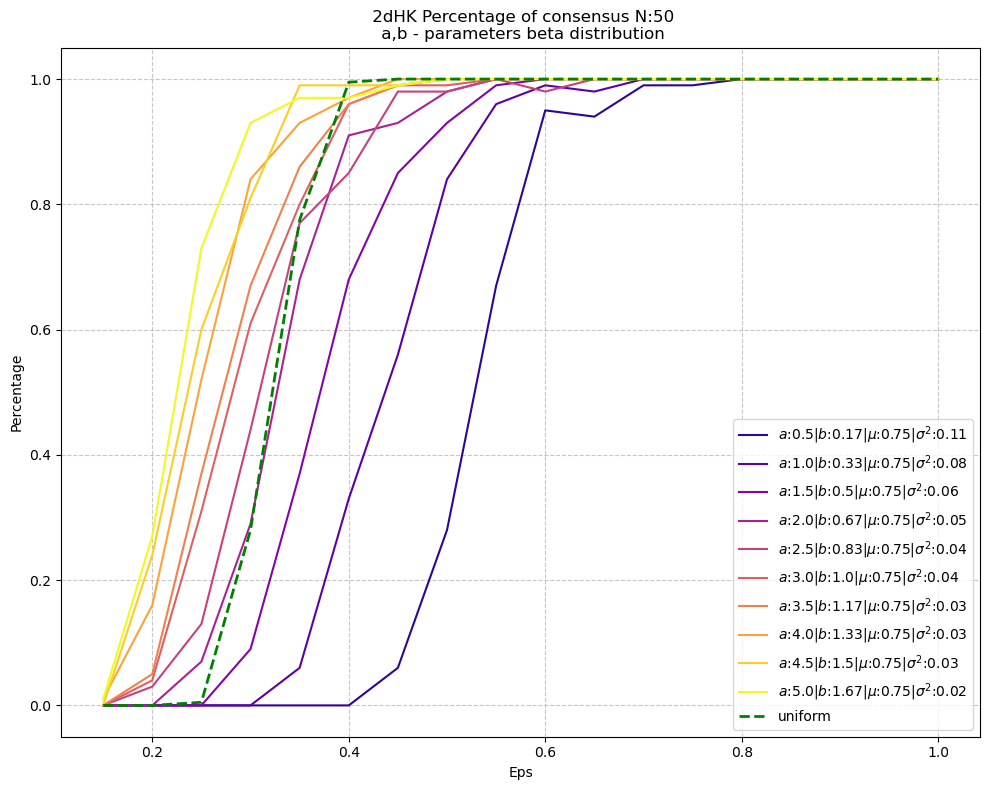

In [160]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0.15, vmax=6.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for i in range (len(alphas)):
    alpha = alphas[i]
    beta = betas[i]
    df = beta_distib_consensus_data.query('beta==@beta and alpha==@alpha and N == @N')
    color=np.array(cmap(norm(beta)+norm(alpha)))
    E, sigma = beta_distrib_ab2Esigma(alpha, beta)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Моделирование для $\alpha=\beta, \mu=0.5$ - фиксированное

In [ ]:
experiment = beta_distib_consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5
for R in R_array:
    for beta in beta_params_array:
        alpha = beta
        init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} b:{beta} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = np.random.beta(alpha, beta, (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = beta_distib_consensus_data[
                    ((beta_distib_consensus_data['N'] == N) 
                     & (beta_distib_consensus_data['alpha'] == alpha) 
                     & (beta_distib_consensus_data['beta'] == beta) 
                     & (beta_distib_consensus_data['eps'] == R))].index[0]
                beta_distib_consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = beta_distib_consensus_data.index[-1] +1

In [108]:
beta_distib_consensus_data[beta_distib_consensus_data['N'] == 50]


,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
80,50.0,0.5,0.5,0.15,0.000000,0.000000,0.0,0.0,100.0
81,50.0,1.0,1.0,0.15,0.000000,0.000000,0.0,0.0,100.0
82,50.0,1.5,1.5,0.15,0.000000,0.000000,0.0,0.0,100.0
83,50.0,2.0,2.0,0.15,0.000000,0.000000,0.0,0.0,100.0
84,50.0,2.5,2.5,0.15,0.000000,0.000000,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...
255,50.0,3.0,3.0,1.00,50.009902,49.682928,100.0,204.0,100.0
256,50.0,3.5,3.5,1.00,49.489846,49.967186,100.0,203.0,100.0
257,50.0,4.0,4.0,1.00,49.694734,50.584541,100.0,200.0,100.0
258,50.0,4.5,4.5,1.00,49.976322,50.289755,100.0,200.0,100.0


Сохранение

In [156]:
beta_distib_consensus_data.to_csv('beta_distib_consensus_data.csv',sep=";", index=False)

Загрузка результатов

In [6]:
data = pd.read_csv('beta_distib_consensus_data.csv', sep=";", dtype=dtypes)
data
# data = beta_distib_consensus_data

,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
0,2500,0.5,0.5,0.15,0.000000,0.000000,0.0,0,10
1,2500,1.0,1.0,0.15,0.000000,0.000000,0.0,0,10
2,2500,1.5,1.5,0.15,0.000000,0.000000,0.0,0,10
3,2500,2.0,2.0,0.15,0.000000,0.000000,0.0,0,10
4,2500,2.5,2.5,0.15,4.003755,3.964977,8.0,153,10
...,...,...,...,...,...,...,...,...,...
255,50,3.0,3.0,1.00,99.779841,99.594450,200.0,410,200
256,50,3.5,3.5,1.00,99.501094,100.260732,200.0,403,200
257,50,4.0,4.0,1.00,99.754001,100.191540,200.0,400,200
258,50,4.5,4.5,1.00,100.258023,99.852555,200.0,400,200


Визуализация

In [119]:
N50 = data[data['N'] == N]
pivot_data = N50.pivot(index='eps', columns='beta', values='consensus_probabity')
pivot_data

beta,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
eps,,,,,,,,,,
0.15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,14.0
0.20,0.0,0.0,0.0,5.0,20.0,56.0,79.0,108.0,137.0,140.0
0.25,0.0,0.0,38.0,113.0,143.0,168.0,176.0,181.0,188.0,191.0
0.30,0.0,54.0,163.0,187.0,197.0,197.0,197.0,199.0,199.0,200.0
0.35,3.0,167.0,196.0,199.0,199.0,200.0,200.0,200.0,200.0,200.0
0.40,55.0,194.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
0.45,149.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
0.50,189.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
0.55,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0


In [7]:
unif_dtypes = {
    'N': np.int64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
unif_data = pd.read_csv('unif_distib_consensus_data.csv', sep=";", dtype=unif_dtypes)

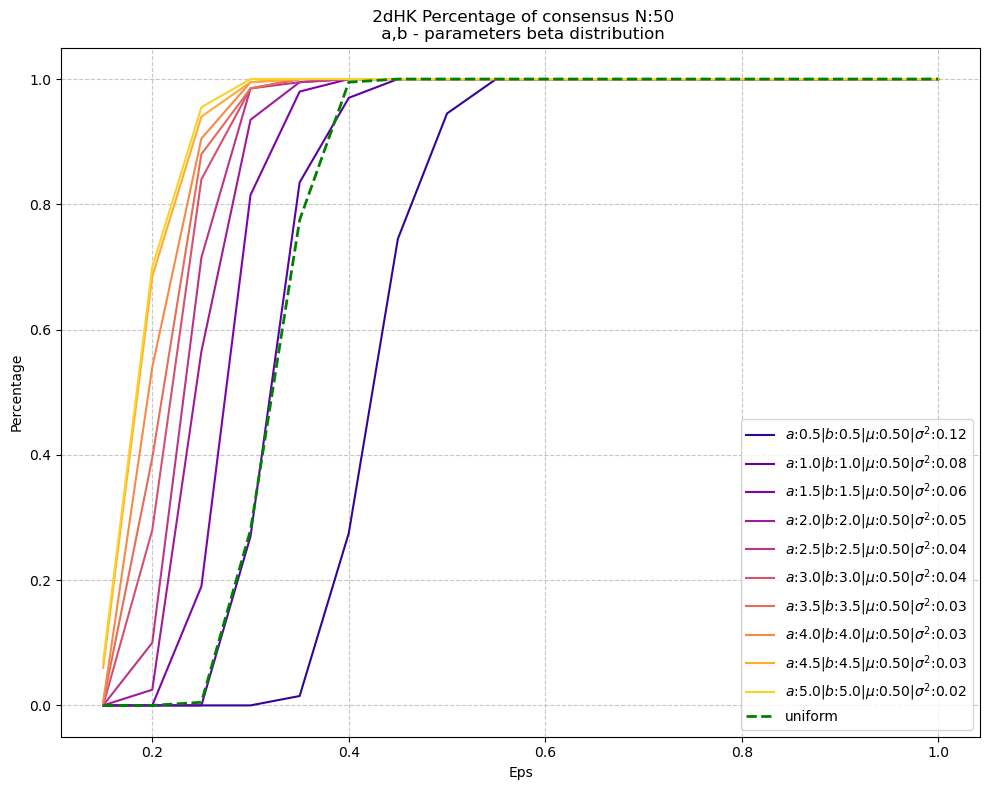

In [21]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0.15, vmax=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for beta in beta_params_array:
    df = data.query('beta == @beta and N == @N')
    color=np.array(cmap(norm(beta)))
    alpha = beta
    E, sigma = beta_distrib_ab2Esigma(alpha, beta)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(beta,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0.15, vmax=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for beta in beta_params_array:
    df = data.query('beta == @beta and N == @N')
    color=np.array(cmap(norm(beta)))
    alpha = beta
    E, sigma = beta_distrib_ab2Esigma(alpha, beta)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(beta,2)}|$b$:{round(beta,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()